In [4]:
import datetime

import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
def importdata():
    dataframe = pd.read_csv('../data/df_points_18-19-20-21_v1_weather_final.csv')
    return dataframe.sort_values(by=['dt_start'])

# Main

In [5]:
df = importdata()
df = df.reset_index(drop=True)
df = df.fillna(0)

df.drop(['time_start','time_end'], axis=1, inplace=True)


In [6]:
## Feature hex_id encoding
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['hex_enc']= label_encoder.fit_transform(df['hex_id'])

#del hex_id
del df['hex_id']

In [7]:
# Add start time Feature
df['start_min'] = np.nan
for ind in tqdm(df.index):
    df['start_min'][ind] = (df['dt_start'][ind] % 86400) / 60

  0%|                                               | 0/2435439 [00:00<?, ?it/s]/var/folders/5t/28jzvs016nq5vxslb670gs040000gn/T/ipykernel_16010/371371022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_min'][ind] = (df['dt_start'][ind] % 86400) / 60
100%|███████████████████████████████| 2435439/2435439 [09:56<00:00, 4083.24it/s]


# Main

In [8]:
#df.to_csv('../data/df_points_18_21_v1_new_features.csv')
df = pd.read_csv('../data/df_points_18_21_v1_new_features.csv')

In [10]:
del df['Unnamed: 0']
df = df.sort_values(by='dt_start')
df.head()

,bike_id,lat,lng,timestood,temp,rain,snow,dt_start,dt_end,hex_enc,start_min
0,3694,51.323619,12.335887,12,10.80,0.0,0.0,1514764029,1514764799,324,1427.15
1,2508,51.323619,12.335887,12,10.80,0.0,0.0,1514764035,1514764799,324,1427.25
2,41851,51.332415,12.395158,2,10.80,0.0,0.0,1514764638,1514764799,137,1437.30
3,2508,51.323619,12.335887,1439,10.86,0.0,0.0,1514764800,1514851199,324,0.00
4,3694,51.323619,12.335887,821,10.86,0.0,0.0,1514764800,1514814103,324,0.00


In [11]:
TargetVariable=['timestood']
Predictors=['bike_id', 'lat', 'lng', 'temp', 'rain', 'snow', 'dt_start','hex_enc','start_min']

X=df[Predictors].values
y=df[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1704807, 9)
(1704807, 1)
(730632, 9)
(730632, 1)


In [12]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
#model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

2022-03-02 12:34:26.697432: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 132.63549194972293
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 131.35814083914957
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 132.2553206421583
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 128.8734280534368
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 129.53082431446146
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 132.30292703224072
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 133.16755090261913
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 127.29496648059899
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 130.722776142631
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 132.11406799744185
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 134.5823438816782
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 126.36981407531609
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 130.51969265759013
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 129.67828888351661
15 Paramete

In [31]:
from keras import backend as K

def coeff_determination(y_test_orig, Predictions):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_test_orig-Predictions ))
    SS_tot = K.sum(K.square( y_test_orig - K.mean(y_test_orig) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])

# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 15, epochs = 50, verbose=1)

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['idle_time']=y_test_orig
TestingData['predicted_idle_time']=Predictions
TestingData.head()

Epoch 1/50
113654/113654 [==============================] - 103s 904us/step - loss: 0.5171 - coeff_determination: 0.3088
Epoch 2/50
113654/113654 [==============================] - 103s 908us/step - loss: 0.5137 - coeff_determination: 0.3127
Epoch 3/50
113654/113654 [==============================] - 102s 901us/step - loss: 0.5109 - coeff_determination: 0.3142
Epoch 4/50
113654/113654 [==============================] - 103s 904us/step - loss: 0.5092 - coeff_determination: 0.3189
Epoch 5/50
113654/113654 [==============================] - 105s 928us/step - loss: 0.5085 - coeff_determination: 0.3183
Epoch 6/50
113654/113654 [==============================] - 104s 919us/step - loss: 0.5079 - coeff_determination: 0.3210
Epoch 7/50
113654/113654 [==============================] - 103s 905us/step - loss: 0.5075 - coeff_determination: 0.3200
Epoch 8/50
113654/113654 [==============================] - 103s 910us/step - loss: 0.5070 - coeff_determination: 0.3211
Epoch 9/50
113654/113654 [======

,bike_id,lat,lng,temp,rain,snow,dt_start,hex_enc,start_min,idle_time,predicted_idle_time
0,41599.0,51.308364,12.379150,-2.99,0.0,0.0,1.616198e+09,98.0,0.000000,648.0,1124.533691
1,97541.0,51.326471,12.342482,21.45,0.0,0.0,1.594997e+09,329.0,888.600000,38.0,150.375244
2,41767.0,51.335989,12.326128,19.11,0.0,0.0,1.532736e+09,352.0,0.000000,1439.0,1097.991089
3,93543.0,51.359000,12.376219,8.36,0.0,0.0,1.587600e+09,261.0,0.000000,268.0,795.621826
4,97714.0,51.320307,12.425492,10.08,0.0,0.0,1.586595e+09,110.0,537.266667,902.0,297.635590


In [32]:
# Computing the absolute percent error
APE=100*(abs(TestingData['idle_time']-TestingData['predicted_idle_time'])/TestingData['idle_time'])
TestingData['APE']=APE

print('The Accuracy of ANN model is:', 100-np.mean(APE))
TestingData.head()

The Accuracy of ANN model is: -inf


,bike_id,lat,lng,temp,rain,snow,dt_start,hex_enc,start_min,idle_time,predicted_idle_time,APE
0,41599.0,51.308364,12.379150,-2.99,0.0,0.0,1.616198e+09,98.0,0.000000,648.0,1124.533691,73.539150
1,97541.0,51.326471,12.342482,21.45,0.0,0.0,1.594997e+09,329.0,888.600000,38.0,150.375244,295.724327
2,41767.0,51.335989,12.326128,19.11,0.0,0.0,1.532736e+09,352.0,0.000000,1439.0,1097.991089,23.697631
3,93543.0,51.359000,12.376219,8.36,0.0,0.0,1.587600e+09,261.0,0.000000,268.0,795.621826,196.873816
4,97714.0,51.320307,12.425492,10.08,0.0,0.0,1.586595e+09,110.0,537.266667,902.0,297.635590,67.002706


In [ ]:
TestingData['APE']

In [1]:
# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model

###########################################
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Listing all the parameters to try
Parameter_Trials={'batch_size':[10,20,30],
                      'epochs':[10,20],
                    'Optimizer_trial':['adam', 'rmsprop']
                 }

# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)

###########################################
from sklearn.metrics import make_scorer

# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)

custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)

#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                         cv=5)

#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()

# Running Grid Search for different paramenters
grid_search.fit(X,y, verbose=1)

EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

print('### Printing Best parameters ###')
grid_search.best_params_

KeyboardInterrupt: 

In [20]:
from sklearn.neural_network import MLPRegressor
import numpy as np

neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)

/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
neural_net.predict([])

---

In [66]:
# Split into Train and Testset

spliting_date = 1609495678
splitting_ind = df.index[df['dt_start']>spliting_date].tolist()[0]

X_train = df.loc[:splitting_ind].drop(['timestood'], axis = 1)
y_train = df.loc[:splitting_ind, 'timestood']

X_test = df.loc[splitting_ind:].drop(['timestood'], axis = 1)
y_test = df.loc[splitting_ind:, 'timestood']

print(f"splitting Sets on: {pd.to_datetime(spliting_date,unit='s')}")
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} y_test: {y_test.shape}")

splitting Sets on: 2021-01-01 10:07:58
X_train: (1803005, 10) y_train: (1803005,)
X_test: (632435, 10) y_test: (632435,)


In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

regr = MLPRegressor(max_iter=500).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

-0.3900473628135068

In [69]:
regr.predict(X_test)
regr.score(X_test, y_test)

-0.3900473628135068

In [54]:
import sklearn.metrics as metrics
pd.options.mode.chained_assignment = None


def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [55]:
# Split into Train and Testset

spliting_date = 1609495678
splitting_ind = df.index[df['dt_start']>spliting_date].tolist()[0]

X_train = df.loc[:splitting_ind].drop(['timestood'], axis = 1)
y_train = df.loc[:splitting_ind, 'timestood']

X_test = df.loc[splitting_ind:].drop(['timestood'], axis = 1)
y_test = df.loc[splitting_ind:, 'timestood']

print(f"splitting Sets on: {pd.to_datetime(spliting_date,unit='s')}")
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} y_test: {y_test.shape}")

NN: -0.371772 (2.624732)


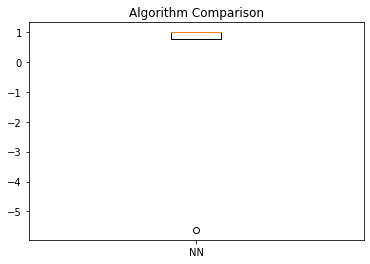

In [56]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import sklearn

import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning


# Spot Check Algorithms
models = []
#models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
#models.append(('KNN', KNeighborsRegressor()))
#models.append(('RF', RandomForestRegressor(n_estimators = 10)))
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        cv_results = cross_val_score(model, X_train, y_train, scoring='r2')

    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [57]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [58]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,10)]
}

model = MLPRegressor(solver = 'lbfgs')
param_list = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_list, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: o

KeyboardInterrupt: 

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

In [ ]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [31]:
df.to_csv('../data/df_points_18_21_v1_new_features.csv')